# Sampling from the GP Prior

Since GPs are non-parametric, we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution $p(f) = \mathcal{N} (\mu, \Sigma)$. Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu = 0$. The covariance matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the input points.

Throughout this notebook, we will explore different covariance functions (also referred to as kernels) and their impact on the GP prior.

In [7]:
# Import basic python libraries
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt

## A stationary covariance function: The RBF Kernel

The widely used squared-exponential (RBF) kernel is defined between two points as: 

$$k(x, x') = \sigma_f^2 \exp \Big( -\dfrac {(x-x')^2}{2l^2} \Big). $$

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_f^2$ . Given that the true
function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_n^2$ , to
the diagonal entries of the resulting kernel matrix, $K$, such that

$$K_y = K + \sigma_n^2I.$$

It is called stationary because it only depends on the difference $\tau = x-x'$ and can therefore be parameterized as $k(\tau)$. An intriguing insight about this kernel is that there exists an infinite-dimensional feature map $\Phi(x)$ for which $k(x, x') = \Phi(x)^{\top} \Phi(x')$.

<div class="alert alert-info">
<strong>Assignment</strong>
    
Complete the `rbf_kernel()` function for computing the RBF kernel $K$ between two sets of input points.

Hint: The ‘cdist’ function in scipy can be used for evaluating the pairwise Euclidean distance between two sets of points.

Note that this function requires the input arrays to be two-dimensional.

The one-dimensional input array $x$ can be made two-dimensional (n_samples, 1) using `np.expand_dims(x, axis=1)`.
</div>

In [80]:
# We define our inputs:
xlim = (-4, 4)
X = np.linspace(*xlim, num=100)

In [46]:
# Solution
def rbf_kernel(x1, x2, lengthscale, variance):
    x1 = np.expand_dims(x1, axis=1)
    x2 = np.expand_dims(x2, axis=1)
    
    return variance*np.exp(-scipy.spatial.distance.cdist(x1, x2)**2/(2*lengthscale**2))

### Plot the RBF Kernel

Use the following code to plot the RBF kernel with respect to the difference between the inputs.

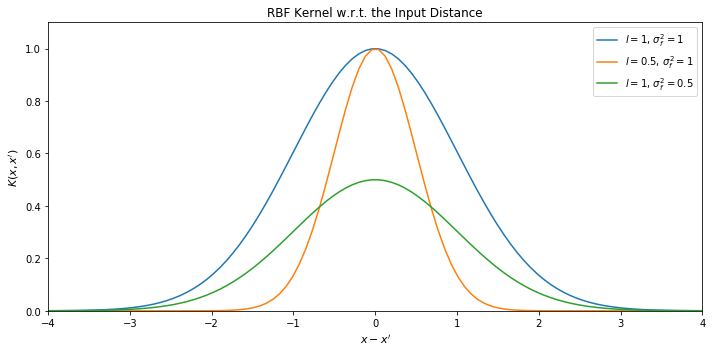

In [37]:
zero = np.array([0.])

fig, ax = plt.subplots(figsize=(10, 5))
Σ = rbf_kernel(
zero, X, lengthscale=1, variance=1)
ax.plot(X, Σ[0,:], label='$l = 1$, $\\sigma_f^2 = 1$')
Σ = rbf_kernel(
zero, X, lengthscale=0.5, variance=1)
ax.plot(X, Σ[0,:], label='$l = 0.5$, $\\sigma_f^2 = 1$')
Σ = rbf_kernel(
zero, X, lengthscale=1., variance=0.5)
ax.plot(X, Σ[0,:], label='$l = 1$, $\\sigma_f^2 = 0.5$')
ax.set_xlabel("$x - x'$", fontsize=11)
ax.set_ylabel("$K(x,x')$", fontsize=11)
ax.set_title('RBF Kernel w.r.t. the Input Distance')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()

### Draw Samples from the Prior

<div class="alert alert-info">
<strong>Assignment</strong>

Complete the code below to draw samples from the GP prior using the RBF kernel. What impact do the variance and lengthscale parameters have on the functions that are drawn from the prior?
</div>

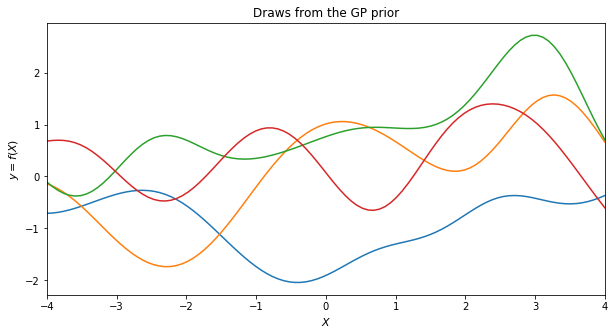

In [58]:
# Solution

n_prior_samples = 4

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_prior_samples):
    K = rbf_kernel(X,X,lengthscale=1,variance=1)
    R = np.random.multivariate_normal(mu, K)
    ax.plot(X,R)
    
ax.set_xlabel("$X$", fontsize=11)
ax.set_ylabel("$y=f(X)$", fontsize=11)
ax.set_title('Draws from the GP prior')

plt.xlim([-4, 4])
plt.show()

## A Dot-Product Covariance Function: The Polynomial Kernel

Up until now, we have focused exclusively on the RBF kernel.
However, the choice of kernel function (along with its associated parameters) can have a significant effect on the overall Gaussian process model.
Choosing the best kernel to fit your data is no simple task, and is a pertinent problem in many applied domains.

A brief discussion on this problem may be found here: <a target="_blank" href="https://www.cs.toronto.edu/~duvenaud/cookbook/">Kernel Cookbook</a>.

In the following, we will have a look at the polynomial kernel:

$$ k(x, x') = \sigma_f^2 \Big( x^{\top} x' + c \Big)^d $$

$c \geq 0$ and $\sigma_f^2$ are parameters of the kernel and $d \in \mathbb{N}$ is the degree.

When setting $c=0$ and $d=1$, we have a simple linear kernel.

Polynomial kernels are interesting because their explicit feature maps are known and finite:

E.g. in the case of two-dimensional inputs and parameters $c=0, \sigma_f^2=1$ and $d=2$, we have:

$$ k(x, x') = \big( x^{\top} x' \big)^2 = \big(x_1^2, \sqrt{2} x_1 x_2, x_2^2\big) \big(x_1'^2, \sqrt{2} x_1' x_2', x_2'^2\big)^{\top} = \Phi(x)^{\top} \Phi(x') $$

Therefore, the associated features $\Phi(x)$ to the kernel are the $d$th degree ordered products of the entries of $x$. Setting $c>0$ will also add lower-order terms to this expansion. This can be seen by expanding $\big( x^{\top} x' + c \big)^2 = \big( x^{\top} x' \big)^2 + 2 c \big( x^{\top} x' \big) + c^2$.

This kernel is non-stationary, which is why it cannot be plotted with respect to the difference of the inputs.

### Plot the Kernel

<div class="alert alert-info">
<strong>Assignment</strong>

Although the kernel cannot be plotted with respect to the difference of the inputs, its angular dependence can be shown. Find a way to plot the kernel against the angle for unit-normalized inputs and $c=0, \sigma_f^2=1$. What can you conclude from the plot?
</div>

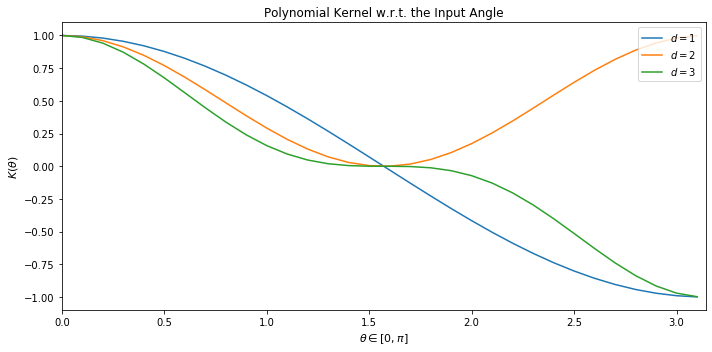

In [77]:
# Solution:

# We have: (x^T x)^d = norm(x)^d norm(x')^d cos(theta)^d = cos(theta)^d
# The kernel is periodic (cosine) and reaches a maximum at theta=0 (aligned vectors).

def poly_norm_kernel(theta, degree):
    return np.cos(theta)**degree

angles = np.arange(0, np.pi, 0.1)
kernel_values = poly_norm_kernel(angles, 2)

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel("$\\theta \in [0, \pi]$", fontsize=11)
ax.set_ylabel("$K(\\theta)$", fontsize=11)
ax.set_title('Polynomial Kernel w.r.t. the Input Angle')

ax.plot(angles, poly_norm_kernel(angles, 1), label='$d=1$')
ax.plot(angles, poly_norm_kernel(angles, 2), label='$d=2$')
ax.plot(angles, poly_norm_kernel(angles, 3), label='$d=3$')
ax.set_xlim([0, np.pi])
ax.legend(loc=1)
plt.tight_layout()
plt.show()

### Draw Samples from the GP Prior

<div class="alert alert-info">
<strong>Assignment</strong>

Once again, you are asked to draw sample functions from the GP prior using the polynomial kernel. Comment on the effect of the kernel parameters.

In particular, what is the effect of $c$? Illustrate this effect with the linear kernel.
</div>

In [106]:
# We define our inputs:
xlim = (-4, 4)
X = np.linspace(*xlim, num=100)

In [108]:
# Solution
def poly_kernel(x1, x2, c, d, variance):
    x1 = np.expand_dims(x1, axis=1)
    x2 = np.expand_dims(x2, axis=1)
    
    return variance * (np.dot(x1, x2.T) + c)**d

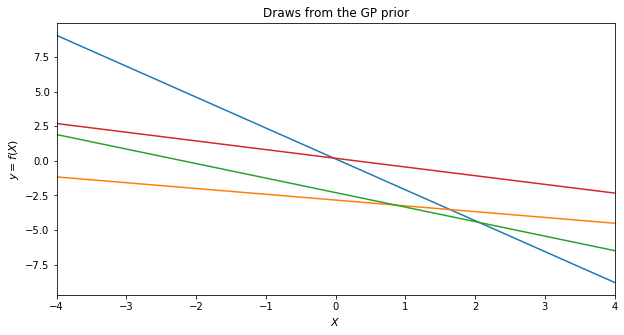

In [113]:
# Solution (degree 1)
# Adding the constant c is the same as adding a bias term to the inputs.
# It allows the functions to move away from 0 at x=0.
# This way, the covariance becomes c instead of 0 at that point.
# A 0 covariance means draws from N(0,0) which have to be 0!

n_prior_samples = 4

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_prior_samples):
    K = poly_kernel(X, X, c=5, d=1, variance=1)
    R = np.random.multivariate_normal(mu, K)
    ax.plot(X,R)
    
ax.set_xlabel("$X$", fontsize=11)
ax.set_ylabel("$y=f(X)$", fontsize=11)
ax.set_title('Draws from the GP prior')

plt.xlim([-4, 4])
plt.show()

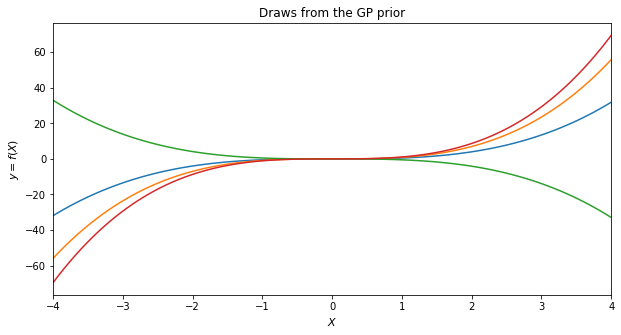

In [107]:
# Solution (degree 3)

n_prior_samples = 4

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_prior_samples):
    K = poly_kernel(X, X, c=0, d=3, variance=1)
    R = np.random.multivariate_normal(mu, K)
    ax.plot(X,R)
    
ax.set_xlabel("$X$", fontsize=11)
ax.set_ylabel("$y=f(X)$", fontsize=11)
ax.set_title('Draws from the GP prior')

plt.xlim([-4, 4])
plt.show()

## Bonus: Arccos Kernel

Have a look at the paper Kernel Methods for Deep Learning by Youngmin Cho and Lawrence K. Saul:

https://papers.nips.cc/paper/3628-kernel-methods-for-deep-learning.pdf

It draws connections between Deep Learning and Deep Kernels as a composition of random features inside a neural network.

In particular, they discuss the Arccos Kernel for which the features correspond to a neural network layer with its weights drawn from a Gaussian i.i.d. prior. The authors propose a number of activation functions (including the widely-used ReLU) and their connection to different degrees of the Arccos Kernel.

<div class="alert alert-info">
<strong>Assignment</strong>

Plot the Arccos Kernel for different angles and draw samples from the GP prior.

Explain the connection between a Bayesian Neural Network prior and a GP prior. Radford Neal's thesis is a helpful resource to consult here:
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf
</div>